In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" # If you have more than one GPU, use this to select the one you want to use

from matplotlib import pyplot as plt
from PIL import Image
import albumentations as A
import pandas as pd
import numpy as np
import sys
import cv2

sys.path.insert(0, "../packages/python")
from data import utils as data_utils
from data import augmentation as data_augmentation
from models import cell_segmentation as segmentators


2024-12-01 18:16:43.414887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733087803.501292   39794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733087803.525588   39794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 18:16:43.717144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cell Segmentation Examples

This notebook has some examples on how the ´CellMaskGenerator´ class (and its childs) work.

### Segment Anything Model (SAM)

Download checkpoint files here: https://pypi.org/project/segment-anything-py/#model-checkpoints

This models requieres 16 GB of RAM (or VRAM) to work.


In [2]:
# Location of the model, input data and output location, modify to your structure
SAM_CHECKPOINT_PATH = "../media/models/SAM/sam_vit_h_4b8939.pth"
IMAGE_PATH = "../media/data/input/"
OUTPUT = "../output/"
CSV_PATH = os.path.join(OUTPUT, "sam_out_2.csv")
CROPPED_OUTPUT = os.path.join(OUTPUT, "cropped_cells/")
MODELS_PATH = '../models/'
# Select the devicce: 
# "cuda" : Will use the NVIDIA GPU
# "cpu" : Will use the... CPU
DEVICE_USE = "cpu"

In [6]:
# Load Model
cmg = segmentators.SAMCellMaskGenerator(SAM_CHECKPOINT_PATH, model_type = 'vit_h', device = DEVICE_USE)

In [ ]:
# Apply segmentation to the whole
data_utils.dataset_cell_segmentation(cmg, IMAGE_PATH, CSV_PATH)

In [9]:
# Read created data
data_df = pd.read_csv(CSV_PATH)

In [10]:
data_df.head()

,area,x,y,w,h,bbox_area,image,cell_id
0,73792,165,741,579,144,83376,332.png,0
1,55382,2004,0,424,153,64872,332.png,1
2,61648,2436,0,371,301,111671,332.png,2
3,69689,1608,1596,373,320,119360,332.png,3
4,68841,1847,140,438,188,82344,332.png,4


In [11]:
data_df.tail()

,area,x,y,w,h,bbox_area,image,cell_id
503,1315,1644,414,41,40,1640,331.png,111
504,832,1358,1559,33,31,1023,331.png,112
505,1694,1660,893,39,59,2301,331.png,113
506,2950,2483,380,66,58,3828,331.png,114
507,2123,1667,234,44,59,2596,331.png,115


### Tests...

I will remove this in the future

In [4]:
# All this should be (somehow) part of the "generate" method
# I'm leaving that unimplemented because this might not be the best way to do it.
# Also because the actual final mask is never created, "mask_gen_f" contains a per-instance mask.
import cv2 as cv
image_input = cv.imread(os.path.join(IMAGE_PATH, "331.png"))
image_input = cv.cvtColor(image_input, cv.COLOR_BGR2RGB)

mask_gen = cmg.mask_generator.generate(image_input)

mask_gen_f = cmg._filter_masks(mask_gen)

masks_df = cmg._masks_to_df(mask_gen_f, "test-image")

In [5]:
masks_df.head()

,area,x,y,w,h,bbox_area,image,cell_id
0,15288,2157,499,143,131,18733,test-image,0
1,18433,268,1277,180,172,30960,test-image,1
2,18478,330,1671,147,165,24255,test-image,2
3,21786,2788,1925,201,122,24522,test-image,3
4,23054,1778,1898,182,149,27118,test-image,4


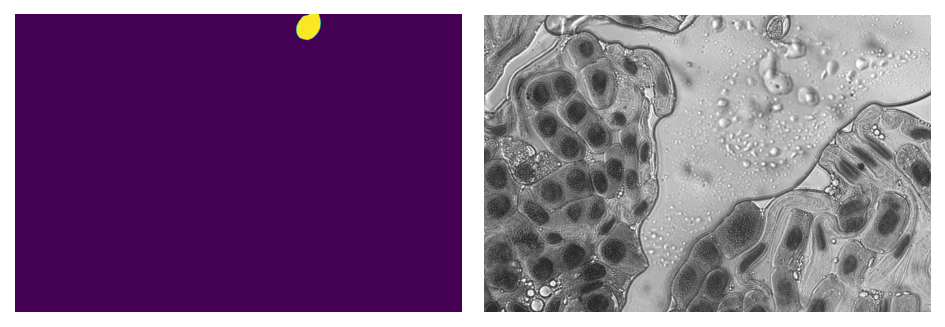

In [6]:
instance_show = 10
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(mask_gen_f[instance_show]["segmentation"])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image_input)
plt.axis("off")
plt.tight_layout()
plt.show()


### Crop nucleai

Using the output csv with the bbox info, the segmentations are cropped from the original image and stored in CROPPED_OUTPUT

In [4]:
def get_file_list(path):
    """
    Gets a list of all files within a specified path, including subdirectories.

    Args:
        path (str): The path to the directory.

    Returns:
        list: A list of file paths.
    """

    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            file_list.append(file_path)
    return file_list

In [ ]:
if not os.path.exists(CROPPED_OUTPUT):
    os.makedirs(CROPPED_OUTPUT)

for file in os.listdir(IMAGE_PATH):
    image_name = os.fsdecode(file)
    image = os.path.join(IMAGE_PATH, image_name)
    cmg.crop_cells(image_path=image, masks_path=CSV_PATH, output_dir=CROPPED_OUTPUT)

### Dataset Augmentation

Using albumination, the dataset formed by the cropped images in CROPPED_OUTPUT is augmented

In [7]:
def augment_image(image):
    # Define the augmentation pipeline
    transform = A.Compose([
        A.Rotate(limit=(-180, 180), p=1),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(p=0.4),
        A.RandomGamma(p=1, gamma_limit=(60, 110)),
        A.GaussNoise(p=0.2)
    ])

    augmented_image = transform(image=image)['image']

    return augmented_image

In [ ]:
output_images = get_file_list(CROPPED_OUTPUT)

for idx, image_path in enumerate(output_images):
    print(f"Image: {idx + 1}/{len(output_images)}", end='\r')

    # Read and augment image
    image = cv2.imread(image_path)
    augmented_image = augment_image(image)

    image_name = os.path.basename(image_path)
    path = os.path.dirname(image_path)
    base_name, ext = os.path.splitext(image_name)

    # Define augmented image name
    new_name = f"{base_name}_augmented{ext}"
    counter = 1
    while os.path.exists(os.path.join(path, new_name)):
        new_name = f"{base_name}_augmented_{counter}{ext}"
        counter += 1

    # Save the augmented image
    cv2.imwrite(os.path.join(path, new_name), augmented_image)




### Apply detected bounding boxes

Looping throught each image in CROPPED_OUTPUT it matches the image with the cell id in the CSV_PATH file to find the original image from where the cell was cropped. Then with the specified model it checks whether the image is a cell or not and if it is, with the bbox data in the csv it draws all the cells their corresponding bbox the in the original image and stores it in ../detected_cells

In [ ]:
CSV_PATH = os.path.join(OUTPUT, "masks.csv")
segmentators.CellMaskGenerator.bbox_applier(model_path=os.path.join(MODELS_PATH,'VGG19.keras'), csv_path=CSV_PATH, cells_path=CROPPED_OUTPUT, images_path=IMAGE_PATH)#, encoder_path=os.path.join(MODELS_PATH, 'encoder2.keras'))

### Compare models detection

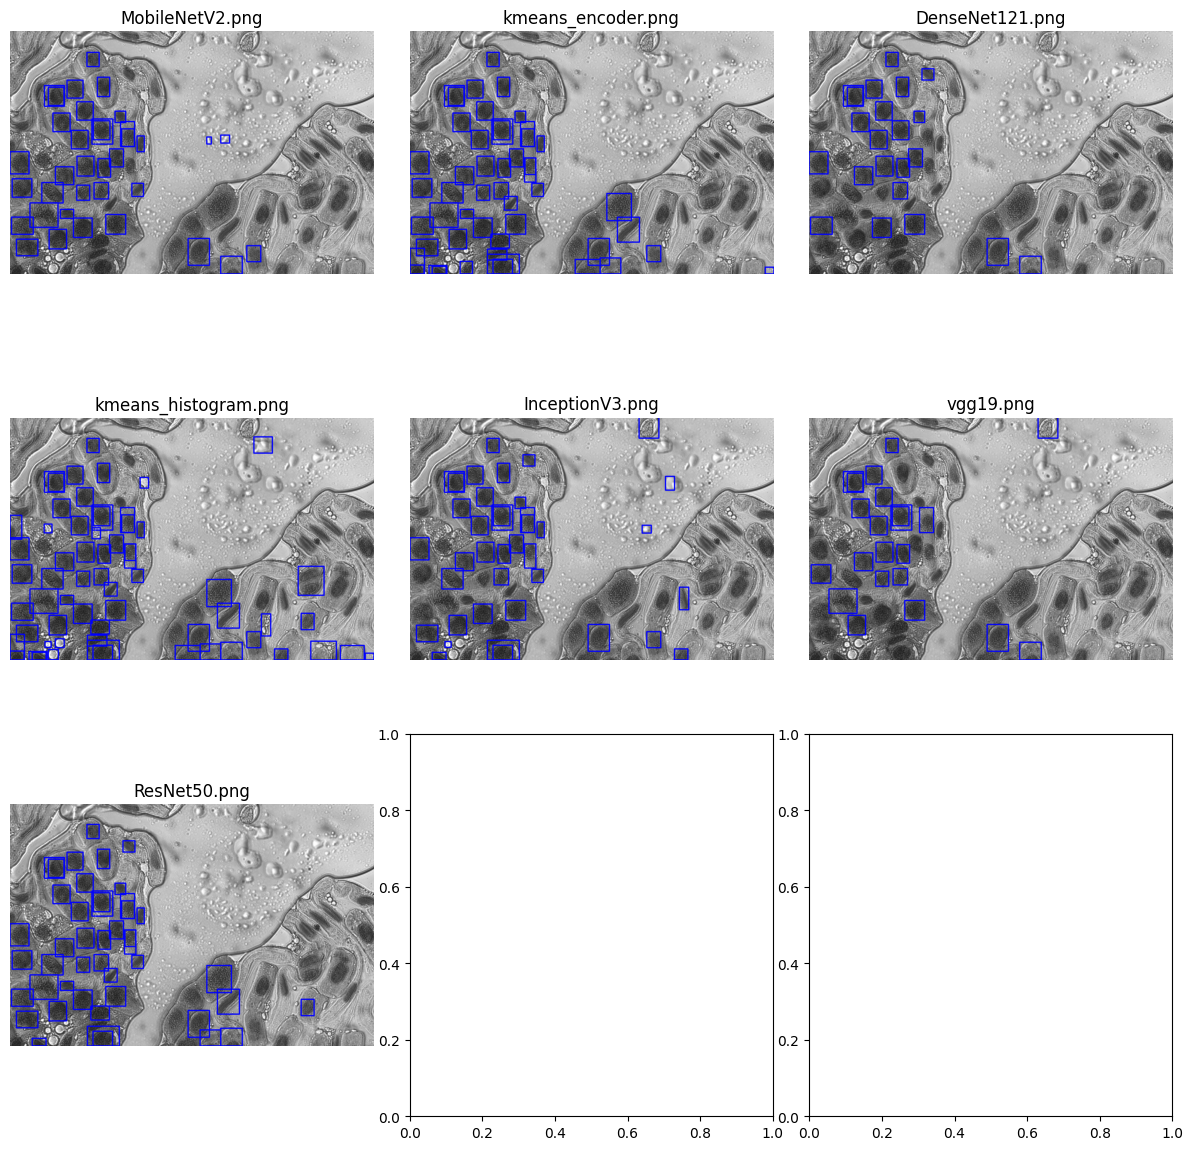

In [11]:
def plot_image_grid(folder_path, rows=4, cols=4):
  """
  Plots a grid of images from a given folder.

  Args:
    folder_path: Path to the folder containing images.
    rows: Number of rows in the grid.
    cols: Number of columns in the grid.
  """

  fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

  # Adjust spacing between subplots
  fig.subplots_adjust(hspace=0.01, wspace=0.1)  # Reduce spacing

  image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))]

  for ax, image_path in zip(axes.flat, image_paths):
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(image_path))
    ax.axis('off')

  plt.show()

# Example usage:
folder_path = '../detected_cells/'
plot_image_grid(folder_path, 3, 3)